In [1]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils

In [2]:
max_time = 200
freq_init = np.array([0.05, 0.1, 0.85])
delta = np.array([0.08, 0.05, 0])
sqrt_variance = 0.005 # We could call this the effective population size
# How do you disentangle sequencing noise from this?

In [3]:
def nD_drift(freq, beta):
    return jnp.dot(beta[:, None] - beta, freq) * freq

def nD_diffusion(freq, noise, sqrt_variance):
    diff_mat = -freq * freq[:, None]
    diag_indices = jnp.diag_indices(freq.shape[0])
    diff_mat = diff_mat.at[diag_indices].set(freq * (1 - freq))
    return (sqrt_variance * diff_mat) @ noise

@jit
def MLR_EulerMaruyama(beta, sqrt_variance, freq0, noise):
    @jit
    def _EM_step(freq, noise):
        freq_next = freq + nD_drift(freq, beta) + nD_diffusion(freq, noise, sqrt_variance)
        freq_next = jnp.clip(freq_next, 0., 1.)
        return freq_next, freq_next

    _, freq = lax.scan(_EM_step, init=freq0, xs=noise)
    return freq

(0.0, 1.0)

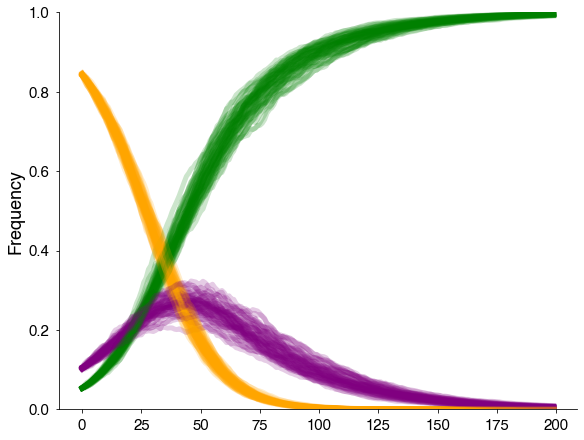

In [4]:
fig = plt.figure(figsize=(8., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=1)

ax_frequency = fig.add_subplot(spec[0, 0])

variants_to_plot = [0,1,2]
colors_to_plot = ["green", "purple", "orange"]

for _ in range(50):
    noise = np.random.normal(size=(200, 3))
    frequency = MLR_EulerMaruyama(delta, 3 * sqrt_variance, freq_init, noise)    
    for v, var in enumerate(variants_to_plot):
        ax_frequency.plot(frequency[:, v], color=colors_to_plot[v], alpha=0.2)

ax_frequency.set_ylabel("Frequency")
ax_frequency.set_ylim((0,1))

In [5]:
# Do we just pass the model earlier
# def ET_drift(freq, delta) and have different classes for models

def ET_drift(freq, beta, escape, S, phi):
    # Compute relative fitness
    delta = beta * S + beta * escape * phi # relative fitness
    return jnp.dot(delta[:, None] - delta, freq) * freq

def EscapeTransmit(beta, escape, S, phi, freq0):
    @jit
    def _ET_step(freq, xs):
        S, phi = xs
        freq_next = freq + ET_drift(freq, beta, escape, S, phi)
        freq_next = jnp.clip(freq_next, 0., 1.)
        return freq_next, freq_next

    _, freq = lax.scan(_ET_step, init=freq0, xs=(S,phi))
    return freq

In [6]:
t = np.arange(100)
S = 1 - np.exp(0.1 * t) / (10. + np.exp(0.1 * t))
phi = (1 - S) * np.exp(-0.02**2 * np.maximum(t - 30, 0.0)**2)

In [7]:
beta = np.array([1., 1.1, 1.0])
escape = np.array([0.1, 0.0, 0.0])

frequency = EscapeTransmit(beta, escape, S, phi, freq_init)

Text(0, 0.5, 'Immune\n population')

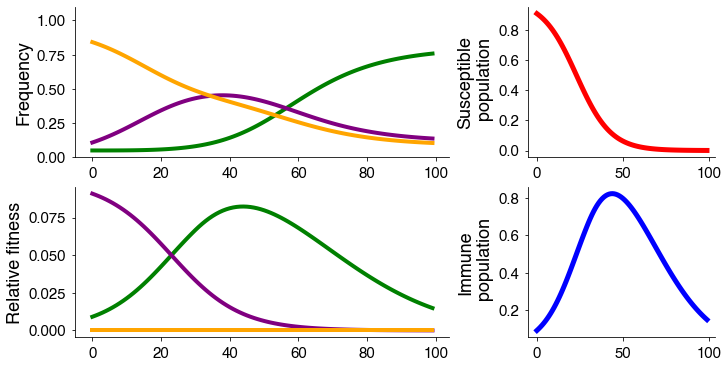

In [8]:
fig = plt.figure(figsize=(10., 5.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.0, 0.5])

ax_frequency = fig.add_subplot(spec[0, 0])

variants_to_plot = [0,1,2]
colors_to_plot = ["green", "purple", "orange"]

frequency = EscapeTransmit(beta, escape, S, phi, freq_init)
for v, var in enumerate(variants_to_plot):
    ax_frequency.plot(frequency[:, v], color=colors_to_plot[v],  linewidth=4.0)

ax_frequency.set_ylabel("Frequency")
ax_frequency.set_ylim((0,1.1))

# Relative fitnessess
ax_rel_fitness = fig.add_subplot(spec[1, 0])

rel_fitness = beta * S[:,None] + beta * escape * phi[:, None]
for v, var in enumerate(variants_to_plot):
    ax_rel_fitness.plot(rel_fitness[:, v] - rel_fitness[:, -1], color=colors_to_plot[v],  linewidth=4.0)
ax_rel_fitness.set_ylabel("Relative fitness")

# Susceptible population and Immune population
ax_S = fig.add_subplot(spec[0, 1])

ax_S.plot(S, color="red", linewidth=5.0)
ax_S.set_ylabel("Susceptible\n population")

ax_phi = fig.add_subplot(spec[1, 1])
ax_phi.plot(phi, color="blue", linewidth=5.0)
ax_phi.set_ylabel("Immune\n population")

In [9]:
# Basically plot relative fitness landscape at different levels of immunity